In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append(str(Path.cwd().parent))

In [2]:
# Directory containing pickle files
directory = Path("../results/classification/quantitative")

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [3]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)

print(df.shape)



(10011, 15)


In [4]:
df.columns

Index(['prox_method', 'conformity_k', 'random_state', 'oob_score_',
       'diff_proba_auc', 'diff_proba_auc_test', 'conformity_auc',
       'conformity_auc_test', 'ice_auc', 'ice_auc_test', 'tree_conformity_auc',
       'tree_conformity_auc_test', 'name', 'n_features', 'n_samples'],
      dtype='object')

In [5]:
df_long = df.melt(
        id_vars=['name', 'random_state', 'prox_method', 'conformity_k'],
        value_vars=[
                'ice_auc', 'diff_proba_auc', 'conformity_auc',
                'ice_auc_test', 'diff_proba_auc_test', 'conformity_auc_test',
                'tree_conformity_auc', 'tree_conformity_auc_test'
        ],
        var_name='metric',
        value_name='auc'
)

In [6]:
df_long

,name,random_state,prox_method,conformity_k,metric,auc
0,optdigits,110269,oob,50,ice_auc,0.991609
1,optdigits,259179,oob,10,ice_auc,0.989286
2,cmc,54887,original,1,ice_auc,0.738314
3,dna,131933,original,1,ice_auc,0.980406
4,wall-robot-navigation,644168,rfgap,5,ice_auc,0.995067
...,...,...,...,...,...,...
80083,kc1,259179,rfgap,100,tree_conformity_auc_test,0.394115
80084,spambase,259179,original,20,tree_conformity_auc_test,0.828114
80085,churn,131933,original,200,tree_conformity_auc_test,0.848689
80086,car,365839,oob,1,tree_conformity_auc_test,0.694403


In [7]:
df_group = df_long.groupby(['prox_method', 'conformity_k', 'metric'])['auc'].agg(['mean', 'std']).reset_index()


In [8]:
df_group

,prox_method,conformity_k,metric,mean,std
0,oob,1,conformity_auc,0.932545,0.100632
1,oob,1,conformity_auc_test,0.934253,0.097316
2,oob,1,diff_proba_auc,0.926252,0.130280
3,oob,1,diff_proba_auc_test,0.930108,0.128460
4,oob,1,ice_auc,0.930008,0.108878
...,...,...,...,...,...
187,rfgap,500,diff_proba_auc_test,0.943224,0.084119
188,rfgap,500,ice_auc,0.934313,0.085554
189,rfgap,500,ice_auc_test,0.938393,0.079136
190,rfgap,500,tree_conformity_auc,0.792525,0.125307


In [9]:
df_group.metric.unique()

array(['conformity_auc', 'conformity_auc_test', 'diff_proba_auc',
       'diff_proba_auc_test', 'ice_auc', 'ice_auc_test',
       'tree_conformity_auc', 'tree_conformity_auc_test'], dtype=object)

In [10]:
df_group.loc[
    df_group['metric'].isin([
        'diff_proba_auc', 'diff_proba_auc_test',
        'tree_conformity_auc', 'tree_conformity_auc_test'
    ]),
    'prox_method'
] = 'NA'

In [11]:
df_group

,prox_method,conformity_k,metric,mean,std
0,oob,1,conformity_auc,0.932545,0.100632
1,oob,1,conformity_auc_test,0.934253,0.097316
2,NA,1,diff_proba_auc,0.926252,0.130280
3,NA,1,diff_proba_auc_test,0.930108,0.128460
4,oob,1,ice_auc,0.930008,0.108878
...,...,...,...,...,...
187,NA,500,diff_proba_auc_test,0.943224,0.084119
188,rfgap,500,ice_auc,0.934313,0.085554
189,rfgap,500,ice_auc_test,0.938393,0.079136
190,NA,500,tree_conformity_auc,0.792525,0.125307


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'conformity_auc'),
  Text(1, 0, 'conformity_auc_test'),
  Text(2, 0, 'diff_proba_auc'),
  Text(3, 0, 'diff_proba_auc_test'),
  Text(4, 0, 'ice_auc'),
  Text(5, 0, 'ice_auc_test'),
  Text(6, 0, 'tree_conformity_auc'),
  Text(7, 0, 'tree_conformity_auc_test')])

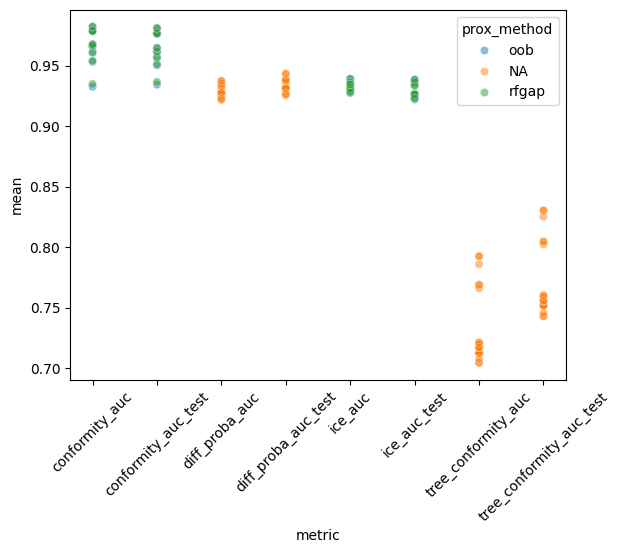

In [12]:
sns.scatterplot(data = df_group[df_group['prox_method'] != 'original'],
                x = 'metric', y = 'mean', hue = 'prox_method',
                alpha = 0.5)
plt.xticks(rotation=45)

/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper 

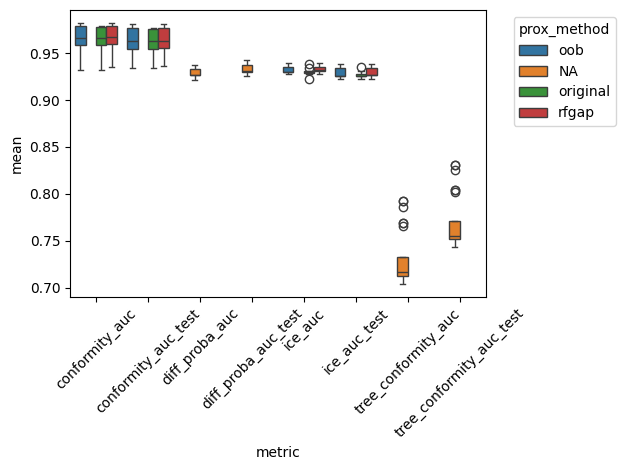

In [13]:
sns.boxplot(
    # data=df_group[df_group['prox_method'] != 'oob'],
    data = df_group,
    x='metric', y='mean', hue='prox_method'
)
plt.xticks(rotation=45)
plt.legend(title='prox_method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [14]:
df_group

,prox_method,conformity_k,metric,mean,std
0,oob,1,conformity_auc,0.932545,0.100632
1,oob,1,conformity_auc_test,0.934253,0.097316
2,NA,1,diff_proba_auc,0.926252,0.130280
3,NA,1,diff_proba_auc_test,0.930108,0.128460
4,oob,1,ice_auc,0.930008,0.108878
...,...,...,...,...,...
187,NA,500,diff_proba_auc_test,0.943224,0.084119
188,rfgap,500,ice_auc,0.934313,0.085554
189,rfgap,500,ice_auc_test,0.938393,0.079136
190,NA,500,tree_conformity_auc,0.792525,0.125307
